[136.0, 121.0, 50.0, 50.0, 78.2, 138.2, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 79.5, 96.2, 53.7, 36.9, 37.3, 65.1, 65.1, 50.0, 50.0, 50.0, 41.9, 41.0, 26.6, 25.8, 53.4, 52.5, 73.5, 74.6, 45.5, 43.1, 57.0, 56.0, 56.0, 50.0, 32.7, 38.0, 87.0, 104.0, 62.0, 68.0, 50.1, 41.9, 20.2, 15.5, 46.7, 27.3, 65.3, 61.7]


TypeError: 'float' object is not callable

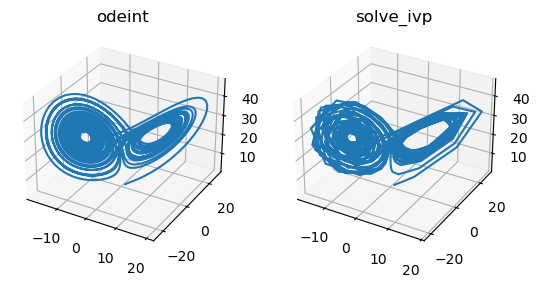

In [5]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
#first task is to look at the various response curves and see how they change with GI
#It should be possible to find a functional form of a response curve that only depends on GI and time?
const = pd.read_excel(r'C:\Users\buddy\Downloads\1-s2.0-S2352939317300374-mmc2.xlsx')

k1_list = []
k2_list = []
k13_list = []
sigma_list = []
carb_list = []

for i in range(51):
    k1_list.append(const.iloc[i][2])
    k2_list.append(const.iloc[i][3])
    k13_list.append(const.iloc[i][4])
    sigma_list.append(const.iloc[i][5])
    carb_list.append(const.iloc[i][6])

print(carb_list)
k1 = 1.45e-2
k2 = 2.76e-1
k3 = 6.07e-3
k4 = 2.35e-4
k5 = 9.49e-2
k6 = 1.93e-1
k7 = 1.15
k8 = 7.27
k9 = 0
k10 = 0
k11 = 3.83e-2
k12 = 2.84e-1
K_M = 13.2 #very different from orginial study, there 2.36e2
a = 1

def f_G(a, k1, sigma, t):
    return a * np.exp(-(k1*t)**sigma)

#Creates all 52 f_G plots
#for i in range(51):
 #   t = np.linspace(0,10,100)
  #  fig, ax = plt.subplots()
   # y = f_G(a, k1_list[i], sigma_list[i], t)
    #ax.plot(t,y, '--')
    #ax.set_title(f"Curve {i+1}")
    #plt.show()
    
def M_out(D_meal,k1, sigma, t):
    return D_meal * np.exp(-(k1*t)**sigma)
   
def M_in(D_meal,k1, sigma, t):
    return D_meal * (1 - np.exp(-(k1*t)**sigma))

#Creates all 52 M_in and M_out plots 
#for i in range (51):
 #   t = np.linspace(0,20,100)
  #  fig, ax = plt.subplots()
   # y = M_in(carb_list[i], k1_list[i], sigma_list[i], t)
    #y2 = M_out(carb_list[i], k1_list[i], sigma_list[i], t)
    #ax.plot(t,y, '--')
    #ax.plot(t,y2, '--')
    #plt.show()
    
def m_G(D_meal,k1, sigma, t):
    return sigma * k1**sigma * t**(sigma-1) * D_meal * np.exp(-(k1*t)**sigma)

#for i in range(52):
 #   t = np.linspace(0,20,100)
  #  fig, ax = plt.subplots()
   # y = m_G(carb_list[i], k1_list[i], sigma_list[i], t)
    #ax.plot(t,y, '--')
    #plt.show()

def m_G(D_meal,k1,k13, sigma, t):
    return sigma * k1**sigma * t**(sigma-1) * D_meal * np.exp(-(k1*t)**sigma)*np.exp(-(k13*t))

#for i in range(51):
 #   t = np.linspace(0,120,100)
  #  fig, ax = plt.subplots()
   # y = m_G(carb_list[i], k1_list[i], k13_list[i], sigma_list[i], t)
    #ax.plot(t,y, '--')
    #plt.show()

#Not necesssary? 
def M_G_gut(D_meal,k1, sigma, t):
    return D_meal * np.exp(-(k1*t)**sigma)

def m_G_gut(D_meal,k1,k13, sigma, t):
    return sigma * k1**sigma * t**(sigma-1) * D_meal * np.exp(-(k1*t)**sigma)*np.exp(-(k13*t))

def m_G_pl(k2, D_meal,k1, sigma, t):
    return k2 * D_meal * np.exp(-(k1*t)**sigma)

#for i in range(51):
 #   t = np.linspace(0,120,100)
  #  fig, ax = plt.subplots()
   # y = M_G_gut(carb_list[i], k1_list[i], sigma_list[i], t)
    #y2 = m_G_gut(carb_list[i], k1_list[i], k13_list[i], sigma_list[i], t)
    #y3 = m_G_pl(k2_list[i], carb_list[i], k1_list[i], sigma_list[i], t)
    #ax.plot(t,y, '--')
    #ax.plot(t,y2, '--')
    #ax.plot(t,y3, '--')
    #plt.show()


#matlab ode15s can be solved with scipy equivalent

#here is a great tutorial on how to solve the ODEs: https://danielmuellerkomorowska.com/2021/02/16/differential-equations-with-scipy-odeint-or-solve_ivp/

#example of how it can be integrated!
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
 
def lorenz(t, state, sigma, beta, rho):
    x, y, z = state
     
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
     
    return [dx, dy, dz]
 
sigma = 10.0
beta = 8.0 / 3.0
rho = 28.0
 
p = (sigma, beta, rho)  # Parameters of the system
 
y0 = [1.0, 1.0, 1.0]  # Initial state of the system

t_span = (0.0, 40.0)
t = np.arange(0.0, 40.0, 0.01)
 
result_odeint = odeint(lorenz, y0, t, p, tfirst=True)
result_solve_ivp = solve_ivp(lorenz, t_span, y0, args=p)
 
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot(result_odeint[:, 0],
        result_odeint[:, 1],
        result_odeint[:, 2])
ax.set_title("odeint")
 
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot(result_solve_ivp.y[0, :],
        result_solve_ivp.y[1, :],
        result_solve_ivp.y[2, :])
ax.set_title("solve_ivp")



def mGut_prime(t, y, D_meal, mPl):
    MGut = y[0]
    return [m_G_gut(D_meal,k1,k13, sigma, t) - mPl(MGut)]

# Define initial conditions and parameters
MGut_0 = 0.0
Dmeal = 10.0
mPl = 0.1
k1 = 1
k13 = 1
sigma = 1

# Define time span and grid
t_span = [0.0, 10.0]
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# Solve the differential equation using solve_ivp
sol = solve_ivp(mGut_prime, t_span, [MGut_0], args=(Dmeal, mPl), t_eval=t_eval)

# Extract the solution for MGut
MGut = sol.y[0]


In [ ]:
import numpy as np
from scipy.integrate import solve_ivp

# define the parameters and initial conditions
Dmeal = 0.8
MGgut = 0.0
usa = 0.1
ila = lambda Ula: 0.007*Ula
ipl = lambda Ipl: 0.03*Ipl
iit = lambda Irem: 0.06*Irem
gliv = lambda Gpl, Irem: 0.01*(80-Gpl) - 0.00015*Gpl*Irem
ggut = lambda MGgut: 0.1*(20-MGgut)
gnonit = lambda Gpl: 0.0001*Gpl
git = lambda Gpl, Irem: 0.00005*Gpl*Irem
gren = lambda Gpl: 0.1*(Gpl-60)
iliv = lambda Ipl: 0.3*(20-Ipl)
irem = lambda Ipl: 0.02*Ipl
Ula = 1

t_start = 0
t_end = 10
t_points = np.linspace(t_start, t_end, 101)
y0 = [80, 0, 0.01, 0, 5]

# define the system of differential equations
def model(t, y, Dmeal, MGgut, usa, ila, ipl, iit, gliv, ggut, gnonit, git, gren, iliv, irem):
    Gpl, Ipl, Usc1, Usc2, Irem = y
    dGpl_dt = gliv(Gpl, Irem) + ggut(MGgut) - gnonit(Gpl) - git(Gpl, Irem) - gren(Gpl)
    dIpl_dt = ipnc(Gpl) + isa(Usc1, Usc2) + ila(Ula) - iliv(Ipl) - irem(Ipl)
    dUsc1_dt = usa - k10*Usc1
    dUsc2_dt = k10*Usc1 - k9*Usc2
    dIrem_dt = ipl(Ipl) - iit(Irem)
    return [dGpl_dt, dIpl_dt, dUsc1_dt, dUsc2_dt, dIrem_dt]

# solve the differential equations
sol = solve_ivp(model, [t_start, t_end], y0, t_eval=t_points, args=(Dmeal, MGgut, usa, ila, ipl, iit, gliv, ggut, gnonit, git, gren, iliv, irem))

import matplotlib.pyplot as plt

# Plot the results
plt.plot(sol.t, sol.y[0], label='Gpl')
plt.plot(sol.t, sol.y[1], label='Ipl')
plt.plot(sol.t, sol.y[2], label='Usc1')
plt.plot(sol.t, sol.y[3], label='Usc2')
plt.plot(sol.t, sol.y[4], label='Irem')
plt.legend(loc='best')
plt.xlabel('Time (min)')
plt.ylabel('Concentration (mM)')
plt.show()

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# solve the differential equations
sol = solve_ivp(model, [t_start, t_end], y0, t_eval=t_points, args=(Dmeal, MGgut, usa, ila, ipl, iit, gliv, ggut, gnonit, git, gren, iliv, irem))

# extract the solution components
Gpl = sol.y[0]
Ipl = sol.y[1]
Irem = sol.y[4]

# create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(Gpl, Ipl, Irem)
ax.set_xlabel('Gpl')
ax.set_ylabel('Ipl')
ax.set_zlabel('Irem')
plt.show()



NameError: name 'ipnc' is not defined

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp

# Define the parameters and initial conditions
Dmeal = 0.8
Ula = 1

# Define the functions for the equations
def mGmeal(Dmeal, t):
    k1 = 0.1
    sigma = 0.5
    return sigma * k1**sigma * t**(sigma-1) * np.exp(-(k1*t)**sigma) * Dmeal

def mGpl(MGgut):
    k2 = 0.2
    return k2 * MGgut

def gliv(Gpl, Irem):
    gbliv = 0.05
    k3 = 0.02
    k4 = 0.03
    Gbpl = 80
    beta = 0.1
    return gbliv - k3*(Gpl - Gbpl) - k4*beta*Irem

def ggut(MGgut):
    k2 = 0.2
    f = 0.05
    nuG = 0.03
    Mb = 0.5
    return k2 * (f / (nuG * Mb)) * MGgut

def gnonit(Gpl):
    gbliv = 0.05
    KM = 50
    Gbpl = 80
    return gbliv * ((KM + Gbpl) / Gbpl) * (Gpl / (KM + Gpl))

def git(Gpl, Irem):
    k5 = 0.04
    beta = 0.1
    KM = 50
    return k5 * beta * Irem * (Gpl / (KM + Gpl))

def gren(Gpl):
    c1 = 0.01
    nuG = 0.03
    Mb = 0.5
    Gthpl = 60
    if Gpl > Gthpl:
        return (c1 / (nuG * Mb)) * (Gpl - Gthpl)
    else:
        return 0

def ipnc(Gpl):
    beta = 0.1
    k6 = 0.02
    Gbpl = 80
    k7 = 0.03
    tau_i = 0.04
    k8 = 0.05
    dGpl_dt = sol.sol(t)[0]  # Interpolated value of dGpl/dt
    t_int = np.linspace(t_start, t, 101)
    integral = np.trapz(sol.sol(t_int)[0] - Gbpl, t_int)
    return (beta**(-1)) * (k6*(Gpl - Gbpl) + (k7/tau_i)*integral + (k7/tau_i)*Gbpl + (k8*tau_i)*dGpl_dt)

def isa(Usc1, Usc2):
    k9 = 0.06
    vI = 0.04
    Mb = 0.5
    return k9 * (1 / (vI * Mb)) * Usc2

def ila(Ula):
    t_half = a * Ula + b
    h = 0.2
    return ((h * t_half**h * t**(h-1)) / ((t_half**h + t**h)**2)) * ((1 / (vI * Mb)) * Ula)

def iliv(Ipl):
    k7 = 0.03
    Gbpl = 80
    beta = 0.1
    tau_i = 0.04
    Ibpl = 0.02
    return k7 * (Gbpl / (beta * tau_i * Ibpl)) * Ipl

def irem(Ipl):
    k11 = 0.07
    Ibpl = 0.02
    return k11 * (Ipl - Ibpl)

def ipl(Ipl):
    return irem(Ipl)

def iit(Irem):
    k12 = 0.08
    return k12 * Irem

# Define the system of differential equations
def model(t, y):
    Gpl, Ipl, Usc1, Usc2, Irem, MGgut = y
    dMGgut_dt = mGmeal(Dmeal, t) - mGpl(MGgut)
    dGpl_dt = gliv(Gpl, Irem) + ggut(MGgut) - gnonit(Gpl) - git(Gpl, Irem) - gren(Gpl)
    dIpl_dt = ipnc(Gpl) + isa(Usc1, Usc2) + ila(Ula, t) - iliv(Ipl) - irem(Ipl)
    dUsc1_dt = usa - k10 * Usc1
    dUsc2_dt = k10 * Usc1 - k9 * Usc2
    dIrem_dt = ipl(Ipl) - iit(Irem)
    return [dGpl_dt, dIpl_dt, dUsc1_dt, dUsc2_dt, dIrem_dt, dMGgut_dt]

# Define the time interval
t_start = 0
t_end = 10
t_points = np.linspace(t_start, t_end, 101)

# Define the initial conditions
y0 = [80, 0, 0.01, 0, 5, 0]

# Solve the differential equations
sol = solve_ivp(model, [t_start, t_end], y0, t_eval=t_points)

import matplotlib.pyplot as plt

# Plot the results
plt.plot(sol.t, sol.y[0], label='Gpl')
plt.plot(sol.t, sol.y[1], label='Ipl')
plt.plot(sol.t, sol.y[2], label='Usc1')
plt.plot(sol.t, sol.y[3], label='Usc2')
plt.plot(sol.t, sol.y[4], label='Irem')
plt.legend(loc='best')
plt.xlabel('Time (min)')
plt.ylabel('Concentration (mM)')
plt.show()

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extract the solution components
Gpl = sol.y[0]
Ipl = sol.y[1]
Irem = sol.y[4]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(Gpl, Ipl, Irem)
ax.set_xlabel('Gpl')
ax.set_ylabel('Ipl')
ax.set_zlabel('Irem')
plt.show()


In [4]:
import sympy as sp

# Define symbols
t = sp.symbols('t')
Dmeal = sp.symbols('Dmeal')
MGgut = sp.Function('MGgut')(t)
Gpl = sp.Function('Gpl')(t)
Ipl = sp.Function('Ipl')(t)
Irem = sp.Function('Irem')(t)
Usc1 = sp.Function('Usc1')(t)
Usc2 = sp.Function('Usc2')(t)
Ula = sp.Function('Ula')(t)

# Define parameters
mGmeal, k1, sigma, k2, gliv, ggut, gnonit, git, gren, f, nuG, Mb, gbliv, k3, Gbpl, k4, beta, KM, c1, Gthpl, ipnc, k6, k7, tau_i, k8, tau_d, isa, k9, vI, k10, ila, h, t_half, k11, Ibpl, k12, ipl, iit = sp.symbols('mGmeal k1 sigma k2 gliv ggut gnonit git gren f nuG Mb gbliv k3 Gbpl k4 beta KM c1 Gthpl ipnc k6 k7 tau_i k8 tau_d isa k9 vI k10 ila h t_half k11 Ibpl k12 ipl iit')

# Define differential equations
dMGgut_dt = mGmeal*(Dmeal.diff(t)) - mGpl*(MGgut)
dGpl_dt = gliv*(Gpl, Irem) + ggut*(MGgut) - gnonit*(Gpl) - git*(Gpl, Irem) - gren*(Gpl)
dIpl_dt = ipnc*(Gpl) + isa*(Usc1, Usc2) + ila*(Ula) - iliv*(Ipl) - irem*(Ipl)
dIrem_dt = ipl*(Ipl) - iit*(Irem)

# Print the differential equations
print('dMGgut/dt =', sp.Eq(dMGgut_dt))
print('dGpl/dt =', sp.Eq(dGpl_dt))
print('dIpl/dt =', sp.Eq(dIpl_dt))
print('dIrem/dt =', sp.Eq(dIrem_dt))

# Define the initial conditions
from scipy.integrate import odeint

# Define parameters
sigma = 0.5
k1 = 0.05
k2 = 0.05
f = 0.8
nuG = 0.8
Mb = 0.1
gbliv = 0.05
k3 = 0.02
Gbpl = 90 
k4 = 0.02
beta = 0.01
KM = 100
k5 = 0.1
c1 = 0.01
Gthpl = 50
ipnc = 0.01
k6 = 0.1
tau_i = 10
k7 = 0.01
k8 = 0.02
k9 = 0.01
vI = 0.5
usa = 0.02
k10 = 0.02
h = 0.5
t_half = 5
a = 0.01
b = 0.01
k11 = 0.01
Ibpl = 0.01
k12 = 0.02

# Define differential equations
def eq_system(y, t):
    MGgut, Gpl, Ipl, Irem, Usc1, Usc2, Ula = y

    dMGgut_dt = mGmeal*(Dmeal,t) - mGpl(MGgut)
    mGmeal = sigma*k1**(sigma) * t**(sigma-1) * exp(-(k1*t)**(sigma))*Dmeal
    mGpl = k2*MGgut

    gliv = gbliv - k3*(Gpl-Gbpl) - k4*beta*Irem
    ggut = k2 * (f / (nuG * Mb)) * MGgut
    gnonit = gbliv*((KM + Gbpl)/ Gbpl)*(Gpl / (KM + Gpl))
    git = k5*beta*Irem*(Gpl / (KM + Gpl))
    gren = (c1/(nuG * Mb))*(Gpl - Gthpl) if Gpl > Gthpl else 0

    dGpl_dt = gliv*(Gpl, Irem) + ggut*(MGgut) - gnonit*(Gpl) - git*(Gpl, Irem) - gren*(Gpl)
    ipnc = (beta**(-1))*(k6*(Gpl-Gbpl) + (k7/tau_i)*quad(lambda x: Gpl(x)-Gbpl, t, t_int)[0] + (k7/tau_i)*Gbpl + (k8*tau_d)*(dGpl_dt))
    isa = k9*(1/(vI*Mb)*Usc2)
    dUsc1_dt = usa - k10*Usc1
    dUsc2_dt = k10*Usc1 - k9*Usc2
    ila = ((h*(t_half)**(h) * t**(h-1)) / (((t_half)**(h) + t**(h))**(2))) * ((1 / (vI*Mb)) * Ula)
    iliv = k7*(Gbpl / (beta*tau_i*Ibpl)) * Ipl
    irem = k



TypeError: can't multiply sequence by non-int of type 'Symbol'

In [1]:
import sympy as sp

# Define symbols
t = sp.symbols('t')
Dmeal, MGgut, Gpl, Irem, Usc1, Usc2, Ula = sp.symbols('Dmeal MGgut Gpl Irem Usc1 Usc2 Ula')
mGmeal, mGpl, gliv, ggut, gnonit, git, gren = sp.symbols('mGmeal mGpl gliv ggut gnonit git gren')
ipnc, isa, ila, iliv, irem, ipl, iit = sp.symbols('ipnc isa ila iliv irem ipl iit')
sigma, k1, k2, k3, k4, beta, KM, k5, c1, Gthpl, k6, k7, tau_i, k8, tau_d, k9, vI, Mb, a, b, h, nuG, f = sp.symbols('sigma k1 k2 k3 k4 beta KM k5 c1 Gthpl k6 k7 tau_i k8 tau_d k9 vI Mb a b h nuG f')
Gbpl, Ibpl = sp.symbols('Gbpl Ibpl')

# Define equations
dMGgut_dt = mGmeal * sp.diff(mGpl * MGgut, t) - mGpl * MGgut
mGmeal_eq = σ * k1**(σ) * t**(σ-1) * sp.exp(-(k1*t)**(σ)) * Dmeal
mGpl_eq = k2 * MGgut
gliv_eq = gbliv - k3 * (Gpl - Gbpl) - k4 * β * Irem
ggut_eq = k2 * (f / (νG * Mb)) * MGgut
gnonit_eq = gbliv * ((KM + Gbpl) / Gbpl) * (Gpl / (KM + Gpl))
git_eq = k5 * β * Irem * (Gpl / (KM + Gpl))
gren_eq = c1 / (νG * Mb) * (Gpl - Gthpl) if Gpl > Gthpl else 0
dGpl_dt = gliv * Gpl + ggut * MGgut - gnonit * Gpl - git * Gpl - gren
ipnc_eq = (β**(-1)) * (k6 * (Gpl - Gbpl) + (k7/τi) * sp.integrate(Gpl - Gbpl, (t_int, t, sp.oo)) + (k7/τi) * Gbpl + k8 * τd * sp.diff(Gpl, t))
isa_eq = k9 * (1 / (vI * Mb)) * Usc2
dUsc1_dt = isa - k10 * Usc1
dUsc2_dt = k10 * Usc1 - k9 * Usc2
t_half_eq = a * Ula + b
ila_eq = ((h * t_half**(h) * t**(h-1)) / ((t_half**(h) + t**(h))**(2))) * ((1 / (vI * Mb)) * Ula)
iliv_eq = k7 * (Gbpl / (β * τi * Ibpl)) * Ipl
irem_eq = k11 * (Ipl - Ibpl)
dIpl_dt = ipnc*(Gpl(t)) + isa*(Usc1(t), Usc2(t)) + ila*(Ula(t)) - iliv*(Ipl(t)) - irem*(Ipl(t))
ipnc(t) = (beta**(-1))*(k6*(Gpl(t) - Gbpl) + (k7/tau_i)*Integral(Gpl(t) - Gbpl, (t, t, t_int)) + (k7/tau_i)*Gbpl + (k8*tau_d)*diff(Gpl(t), t))
isa(t) = k9*(1/(vI*Mb))*Usc2(t)
dUsc1_dt = usa(t) - k10*Usc1(t) 
dUsc2_dt = k10*Usc1(t) - k9*Usc2(t)
ila(t) = ((h*(t_half)**(h) * t**(h-1)) / (((t_half)**(h) + t**(h))**(2))) * ((1 / (vI*Mb)) * Ula)
t_half = a*Ula(t) + b
iliv(t) = k7*(Gbpl / (beta*tau_i*Ibpl)) * Ipl(t)
irem(t) = k11*(Ipl(t) - Ibpl)

dIrem_dt = ipl*(Ipl(t)) - iit*(Irem(t))
ipl(t) = irem(t) = k11*(Ipl(t) - Ibpl)
iit(t) = k12*Irem(t)

Gpl(0) = Gbpl = 90
MGgut(0) = 0
Ipl(0) = Ibpl = 5
Irem(0) = 0
Usc1(0) = 0.1
Usc2(0) = 0
Ula(0) = 2

import numpy as np
from scipy.integrate import solve_ivp

# Define the system of differential equations
def ode_system(t, y, *params):
    # Unpack the variables
    Gpl, MGgut, Ipl, Irem, Usc1, Usc2, Ula = y
    # Unpack the parameters
    mGmeal, k1, sigma, k2, f, nuG, Mb, gbliv, k3, k4, beta, KM, k5, c1, Gthpl, k6, k7, tau_i, Gbpl, k8, tau_d, k9, vI, k10, h, t_half, k11, Ibpl, k12 = params

    # Define the equations for each variable
    dGpl_dt = gliv(Gpl, Irem) + ggut(MGgut) - gnonit(Gpl) - git(Gpl, Irem) - gren(Gpl)
    dMGgut_dt = mGmeal(t) - mGpl(MGgut)
    dIpl_dt = ipnc(Gpl) + isa(Usc1, Usc2) + ila(Ula) - iliv(Ipl) - irem(Ipl)
    dIrem_dt = ipl(Ipl) - iit(Irem)
    dUsc1_dt = usa(Ula) - k10*Usc1
    dUsc2_dt = k10*Usc1 - k9*(1/(vI*Mb))*Usc2
    dUla_dt = ((h*t_half**h * t**(h-1)) / ((t_half**h + t**h)**2)) * (1 / (vI*Mb))

    return [dGpl_dt, dMGgut_dt, dIpl_dt, dIrem_dt, dUsc1_dt, dUsc2_dt, dUla_dt]

# Define the parameter values
mGmeal = lambda t: sigma * k1**(sigma) * t**(sigma-1) * np.exp(-(k1*t)**(sigma)) * Dmeal
Dmeal = 50
k1 = 0.13
sigma = 0.5
k2 = 0.06
f = 0.8
nuG = 0.15
Mb = 10
gbliv = 0.06
k3 = 0.01
k4 = 0.01
beta = 0.1
KM = 100
k5 = 0.1
c1 = 0.01
Gthpl = 90
k6 = 0.04
k7 = 0.05
tau_i = 15
Gbpl = 90
k8 = 0.1
tau_d = 2
k9 = 0.1
vI = 0.2
k10 = 0.02
h = 2
t_half = lambda Ula: 0.5*Ula
k11 = 0.03
Ibpl = 5
k12 = 0.02

# Define the initial conditions
y0 = [Gbpl, 0, Ibpl, 0, 0.1, 0, 2]

# Define the time grid
t_start = 0
t_end = 20
t_step = 0.1

# solve system of differential equations
sol = solve_ivp(ode_system, t_span, y0, method='RK45', t_eval=np.arange(t_span[0], t_span[1] + t_step, t_step))





SyntaxError: cannot assign to function call (1758674979.py, line 30)

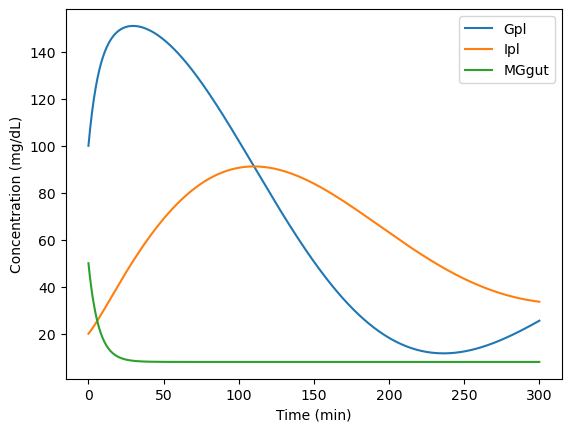

In [9]:
from scipy.integrate import odeint
# Define initial conditions
Gpl0 = 90
Ipl0 = 10
MGgut0 = 0

import numpy as np
from scipy.integrate import odeint

# Define parameters
sigma = 1.2
k1 = 0.05
k2 = 0.06
gliv = 0.02
gbliv = 0.8
k3 = 0.02
k4 = 0.005
beta = 0.1
f = 0.8
nuG = 0.08
Mb = 0.15
KM = 100
c1 = 0.05
Gthpl = 60
ipnc = 0.05
k6 = 0.005
k7 = 0.002
tau_i = 10
Gbpl = 10
k8 = 0.0005
k9 = 0.2
vI = 0.12
k10 = 0.05
h = 4
t_half = 5
a = 0.01
b = 0.1
k11 = 0.001
Ibpl = 5
k12 = 0.01

from scipy.integrate import odeint
import numpy as np

def model(y, t):
    # Unpack state variables
    Gpl, Ipl, MGgut = y

    # Parameter values
    gliv = 0.05
    ggut = 0.15
    gnonit = 0.025
    git = 0.025*Ipl
    gren = 0.025*Gpl

    # Glucose dynamics in the plasma
    dGpl_dt = gliv*Gpl + ggut*MGgut - gnonit*Gpl - git - gren

    # Insulin dynamics in the plasma
    dIpl_dt = -0.01*Ipl + 0.01*Gpl

    # Glucose dynamics in the gut
    dMGgut_dt = -ggut*MGgut + 1.2

    return [dGpl_dt, dIpl_dt, dMGgut_dt]

# Define the meal glucose function
def mGmeal(t):
    if t >= 0 and t < 5:
        return 10
    elif t >= 5 and t < 7:
        return -5*t + 35
    else:
        return 0

# Define the insulin removal function
def Irem(t):
    if t >= 0 and t < 120:
        return 0
    elif t >= 120:
        return 0.02

# Set time points
t = np.linspace(0, 300, 1000)

# Set initial conditions
y0 = [100, 20, 50]

# Solve the differential equation system
sol = odeint(model, y0, t)

# Extract the results
Gpl = sol[:, 0]
Ipl = sol[:, 1]
MGgut = sol[:, 2]

# Plot the results
import matplotlib.pyplot as plt
plt.plot(t, Gpl, label='Gpl')
plt.plot(t, Ipl, label='Ipl')
plt.plot(t, MGgut, label='MGgut')
plt.legend()
plt.xlabel('Time (min)')
plt.ylabel('Concentration (mg/dL)')
plt.show()


In [ ]:
from scipy.integrate import solve_ivp

# Define the system of differential equations
def equations(t, y):
    MGgut, Gpl, Ipl, Usc1, Usc2, Ula, Irem = y

    # Define the constants
    # (Replace these with the actual values from your problem)
    k1 = 1.0
    k2 = 2.0
    k3 = 3.0
    k4 = 4.0
    k5 = 5.0
    k6 = 6.0
    k7 = 7.0
    k8 = 8.0
    k9 = 9.0
    k10 = 10.0
    k11 = 11.0
    k12 = 12.0
    σ = 0.5
    mGpl = 0.1
    gliv = 0.2
    ggut = 0.3
    gnonit = 0.4
    git = 0.5
    gren = 0.6
    ipnc = 0.7
    isa = 0.8
    ila = 0.9
    t_half = 1.0
    iliv = 1.1
    irem = 1.2
    ipl = 1.3
    iit = 1.4
    usa = 1.5
    h = 0.6  # Define the value for h
    vI = 1.0  # Define the value for vI
    Mb = 1.0

    Dmeal_val = 1.0  # Replace with the actual meal intake calculation

    
    dMGgut_dt = mGpl * Dmeal_val - mGpl * MGgut
    dGpl_dt = gliv * (Gpl * Irem) + ggut * MGgut - gnonit * Gpl - git * (Gpl * Irem) - gren * Gpl
    dIpl_dt = ipnc * Gpl + isa * (Usc1 * Usc2) + ila * Ula - iliv * Ipl - irem * Ipl
    dUsc1_dt = usa - k10 * Usc1
    dUsc2_dt = k10 * Usc1 - k9 * Usc2
    dUla_dt = ((h * t_half ** h * t ** (h - 1)) / ((t_half ** h + t ** h) ** 2)) * (1 / (vI * Mb)) * Ula
    dIrem_dt = ipl * Ipl - iit * Irem

    return [dMGgut_dt, dGpl_dt, dIpl_dt, dUsc1_dt, dUsc2_dt, dUla_dt, dIrem_dt]

# Set the initial conditions
# (Replace these with the actual initial values from your problem)
MGgut0 = 0.0
Gpl0 = 1.0
Ipl0 = 2.0
Usc1_0 = 3.0
Usc2_0 = 4.0
Ula0 = 5.0
Irem0 = 6.0
initial_conditions = [MGgut0, Gpl0, Ipl0, Usc1_0, Usc2_0, Ula0, Irem0]

# Set the time span for integration
# (Replace t_start and t_end with your desired time range)
t_start = 0
t_end = 1

# Solve the system of differential equations
solution = solve_ivp(equations, [t_start, t_end], initial_conditions)

# Get the results
t = solution.t
MGgut = solution.y[0]
Gpl = solution.y[1]
Ipl = solution.y[2]
Usc1 = solution.y[3]
Usc2 = solution.y[4]
Ula = solution.y[5]
Irem = solution.y[6]

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(t, MGgut, label='MGgut')
plt.plot(t, Gpl, label='Gpl')
plt.plot(t, Ipl, label='Ipl')
plt.plot(t, Usc1, label='Usc1')
plt.plot(t, Usc2, label='Usc2')
plt.plot(t, Ula, label='Ula')
plt.plot(t, Irem, label='Irem')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the system of differential equations
def equations(y, t):
    MGgut, Gpl, Ipl, Usc1, Usc2, Ula, Irem = y

    # Define the constants
    k1 = 1.0
    k2 = 2.0
    k3 = 3.0
    k4 = 4.0
    k5 = 5.0
    k6 = 6.0
    k7 = 7.0
    k8 = 8.0
    k9 = 9.0
    k10 = 10.0
    k11 = 11.0
    k12 = 12.0
    sigma = 0.5
    mGpl = 0.1
    gliv = 0.2
    ggut = 0.3
    gnonit = 0.4
    git = 0.5
    gren = 0.6
    ipnc = 0.7
    isa = 0.8
    ila = 0.9
    t_half = 1.0
    iliv = 1.1
    irem = 1.2
    ipl = 1.3
    iit = 1.4
    usa = 1.5
    h = 0.6  # Define the value for h
    vI = 1.0  # Define the value for vI
    Mb = 1.0

    Dmeal_val = 1.0  # Replace with the actual meal intake calculation

    dMGgut_dt = mGpl * Dmeal_val - mGpl * MGgut
    dGpl_dt = gliv * (Gpl * Irem) + ggut * MGgut - gnonit * Gpl - git * (Gpl * Irem) - gren * Gpl
    dIpl_dt = ipnc * Gpl + isa * (Usc1 * Usc2) + ila * Ula - iliv * Ipl - irem * Ipl
    dUsc1_dt = usa - k10 * Usc1
    dUsc2_dt = k10 * Usc1 - k9 * Usc2
    dUla_dt = ((h * t_half ** h * t ** (h - 1)) / ((t_half ** h + t ** h) ** 2)) * (1 / (vI * Mb)) * Ula
    dIrem_dt = ipl * Ipl - iit * Irem

    return [dMGgut_dt, dGpl_dt, dIpl_dt, dUsc1_dt, dUsc2_dt, dUla_dt, dIrem_dt]

# Set the initial conditions
MGgut0 = 0.0
Gpl0 = 1.0
Ipl0 = 2.0
Usc1_0 = 3.0
Usc2_0 = 4.0
Ula0 = 5.0
Irem0 = 6.0
initial_conditions = [MGgut0, Gpl0, Ipl0, Usc1_0, Usc2_0, Ula0, Irem0]

# Set the time span for integration
t_start = 0.0
t_end = 100.0
num_points = 1000  # Number of points in the solution

# Generate the time points
t = np.linspace(t_start, t_end, num_points)

# Solve the system of differential equations
solution = odeint(equations, initial_conditions, t)

# Extract the results
MGgut = solution[:, 0]
Gpl = solution[:, 1]
Ipl = solution[:, 2]
Usc1 = solution[:, 3]
Usc2 = solution[:, 4]
Ula = solution[:, 5]
Irem = solution[:, 6]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, MGgut, label='MGgut')
plt.plot(t, Gpl, label='Gpl')
plt.plot(t, Ipl, label='Ipl')
plt.plot(t, Usc1, label='Usc1')
plt.plot(t, Usc2, label='Usc2')
plt.plot(t, Ula, label='Ula')
plt.plot(t, Irem, label='Irem')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define the system of differential equations
def system(y, t):
    Gpl, Ipl, Usc1, Usc2, Irem = y
    
    # Parameters
    gliv = 0.1
    ggut = 0.2
    gnonit = 0.05
    git = 0.15
    gren = 0.08
    ipnc = 0.05
    isa = 0.1
    ila = 0.05
    iliv = 0.12
    irem = 0.07
    k10 = 0.1
    k9 = 0.05
    ipl = 0.15
    iit = 0.09
    
    dGpl_dt = gliv * (Gpl, Irem) + ggut * MGgut(t) - gnonit * Gpl - git * (Gpl, Irem) - gren * Gpl
    dIpl_dt = ipnc * Gpl + isa * (Usc1, Usc2) + ila * Ula - iliv * Ipl - irem * Ipl
    dUsc1_dt = usa(t) - k10 * Usc1
    dUsc2_dt = k10 * Usc1 - k9 * Usc2
    dIrem_dt = ipl * Ipl - iit * Irem
    
    return [dGpl_dt, dIpl_dt, dUsc1_dt, dUsc2_dt, dIrem_dt]

# Define the initial conditions
initial_conditions = [0.5, 0.3, 0.2, 0.1, 0.4]  # Example initial conditions

# Define the time points for evaluation
t = np.linspace(0, 10, 100)  # Adjust the range and number of points as needed

# Solve the system of differential equations
solution = odeint(system, initial_conditions, t)

# Extract the individual variables' solutions
Gpl_solution = solution[:, 0]
Ipl_solution = solution[:, 1]
Usc1_solution = solution[:, 2]
Usc2_solution = solution[:, 3]
Irem_solution = solution[:, 4]

# Plotting the solution curves
plt.figure(figsize=(10, 6))
plt.plot(t, Gpl_solution, label='Gpl')
plt.plot(t, Ipl_solution, label='Ipl')
plt.plot(t, Usc1_solution, label='Usc1')
plt.plot(t, Usc2_solution, label='Usc2')
plt.plot(t, Irem_solution, label='Irem')
plt.xlabel('Time')
plt.ylabel('Solution')
plt.title('Solution Curves')
plt.legend()
plt.grid(True)
plt.show()
